# FuseTS - Fusing S1 RVI  and S2 LVA Data with MOGPR

In this notebook, we will showcase the MOGPR (Multi-Output Gaussian Process Regression) algorithm for fusing Sentinel-1 (S1) RVA and Sentinel-2 (S2) NDVI data. By leveraging the capabilities of the FuseTS library, we will demonstrate how openEO can be utilized to fetch the input data required for the MOGPR algorithm.

Through this tutorial, you will learn how to load and preprocess S1 and S2 data using openEO, and perform the fusion of the two datasets through the MOGPR service. We will also showcase visualization 

**Prerequisites**
* In this notebook we are using openEO to fetch the time series data for the meadow. You can register for a free trial account on the [openEO Platform](https://openeo.cloud/#plans) website.

In [3]:
import openeo
from shapely.geometry import box
import pandas as pd
import numpy as np
from openeo.rest.conversions import timeseries_json_to_pandas
from datetime import datetime
import os
import sys

# Add local version of FuseTS
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fusets.mogpr import mogpr_1D

### Data aquisition

In this notebook we will be focussing on a test site from an agricultural area based in Castilla and León (Spain). 

In [4]:
from IPython.display import display, Image
display(Image(url ='https://github.com/Open-EO/FuseTS/blob/main/notebooks/AI4FOOD_ITACYL_subsets.png?raw=true'))

In the data retrieval, executed through openEO, we will leverage openEO's capabilities to fetch the necessary data for fusion. For the Sentinel-1 data, we will retrieve the S1 GRD data and calculate the RVI using openEO's band math functionalities. For the Sentinel-2 (S2) data, we will process the L2A data and compute the NDVI. These steps will enable us to obtain the required S1 and S2 data in a format suitable for the MOGPR fusion.

In [12]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


To retrieve AOI data from the year 2019, the spatiotemporal extent is determined as follows

In [13]:
spat_ext = {"west":-4.8909914254212605,"east":-4.820438599493526,"south":41.74687686378393,"north":41.79965426256652}
temp_ext = ["2015-11-20","2019-12-31"]

Next we start with the extraction of RVI times series from Sentinel-1 (Ascending and Descending) and Sentinel-2 Level-2A NDVI.

In [14]:
from openeo.processes import eq
s1_desc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'DESCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )


VH = s1_desc.band("VH")
VV = s1_desc.band("VV")
rvi_desc_cube = (VH + VH) / (VV + VH)

s1_asc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'ASCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
VH = s1_asc.band("VH")
VV = s1_asc.band("VV")
rvi_asc_cube = (VH + VH) / (VV + VH)

s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
ndvi_cube = s2.ndvi(red="B04", nir="B08")

/home/bramjanssen/.local/lib/python3.6/site-packages/openeo/rest/connection.py:1006: UserWarning: SENTINEL1_GRD property filtering with properties that are undefined in the collection metadata (summaries): resolution.
  fetch_metadata=fetch_metadata,


In the next step we define the different subsets we want to process. These subsets are fields (different croptypes) that are located in the main area of the our input data. 

In [8]:
from shapely.geometry import box
subsets = {
    'Rye' : box(-4.867495201109149, 41.77850665915476, -4.865177772520282, 41.780106793555454),
    'Rape' : box(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532),
    'Barley' : box(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915),
    'Wheat' : box(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)    
}

As an example, we will select one subset to process.

In [9]:
crop = 'Wheat'
point_area = subsets[crop]

Now, we can start with calculating the time series values for the selected subset. We'll calculate a time series for all available data cubes (NDVI, RVI ASC, RVI DESC). The final timeseries are combined in a single dataframe.

In [15]:
cubes_dfs = []
for cube in [ndvi_cube, rvi_desc_cube, rvi_asc_cube]:
    point_timeseries = cube.polygonal_mean_timeseries(point_area).execute()
    df = timeseries_json_to_pandas(point_timeseries)
    df.index = pd.to_datetime(df.index)
    cubes_dfs.append(df) 

# Join signal dfs
subset_df = pd.concat(cubes_dfs, axis=1)
subset_df = subset_df.rename(columns={0: 'NDVI', 1: 'RVI_DESC', 2: 'RVI_ASC'})  

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserDeprecationWarning: Call to deprecated method polygonal_mean_timeseries. (Use `aggregate_spatial` with reducer ``'mean'``.) -- Deprecated since version 0.10.0.
  This is separate from the ipykernel package so we can avoid doing imports until


We can now visualize the dataframe in a graph. The time series data is now ready to be processed by the MOGPR algorithm.

(0, 1)

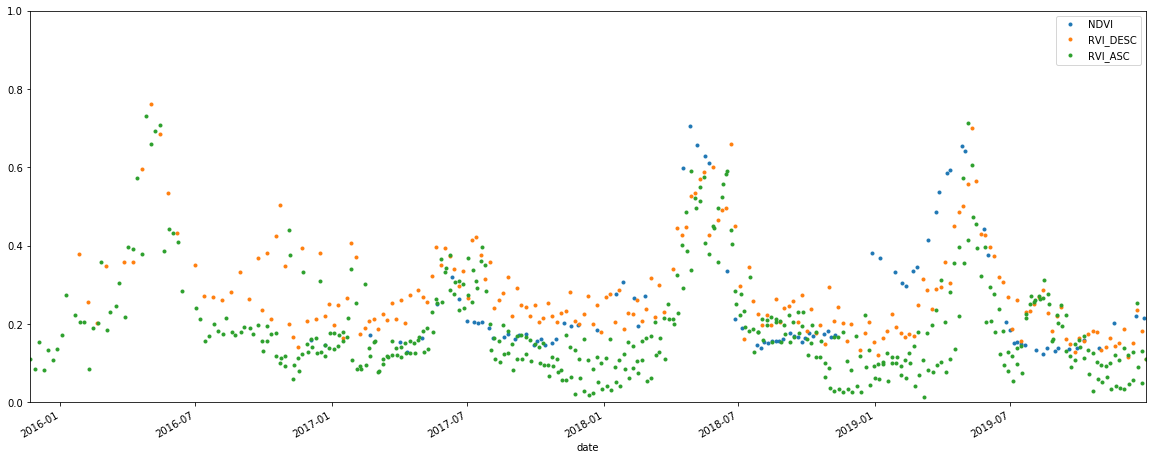

In [23]:
plot = subset_df.plot(figsize=(20,8), marker='.', linestyle='None')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])

### Executing MOGPR

In order to process the time series data, some additional preprocessing is required to execute the MOGPR algorithm. This includes extracting the different time steps that are available in the input data.

In [31]:
# Use only 2 signals
signals = ['NDVI', 'RVI_DESC']

time_step = 15
time       = []
data       = []
time_str   = []

for signal in signals:
    time_vec_num = np.asarray([ _.toordinal() for _ in subset_df.index], dtype=np.float64)        
    time.append(time_vec_num)
    data.append(subset_df[signal].to_numpy())         

time_vec_min        = np.min(list(pd.core.common.flatten(time)))
time_vec_max        = np.max(list(pd.core.common.flatten(time)))
output_timevec      = np.array(range(int(time_vec_min), int(time_vec_max), time_step), dtype = np.float64)  
output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]

Now we can actually execute the MOGPR model by using the `mogpr_1D` function from the FuseTS toolbox. This function accepts the following parameters:

* `data_in` (list): List of numpy 1D arrays containing data to be processed
* `time_in` (list): List of numpy 1D arrays containing the (ordinal)dates of each variable in the time dimension
* `master_ind` (int): Index identifying the Master output
* `output_timevec` (array) : Vector containing the dates on which output must be estimated
* `nt` [int]: # of times the GP training must be performed (def=1)

In [32]:
master_ind = 1
nt = 1
out_mean, out_std, out_qflag, out_model = mogpr_1D(data[:], time[:],master_ind,output_timevec,nt)

Let's convert the output of the service to a pandas dataframe and plot the results.

In [33]:
nout = len(out_mean)
out_mean_list = []
for ind in range(nout):
    out_mean_list.append(out_mean[ind].ravel())
    
df_mogpr_out_mean = pd.DataFrame(np.column_stack(out_mean_list), columns=signals)
df_mogpr_out_mean.index = output_time

(0, 1)

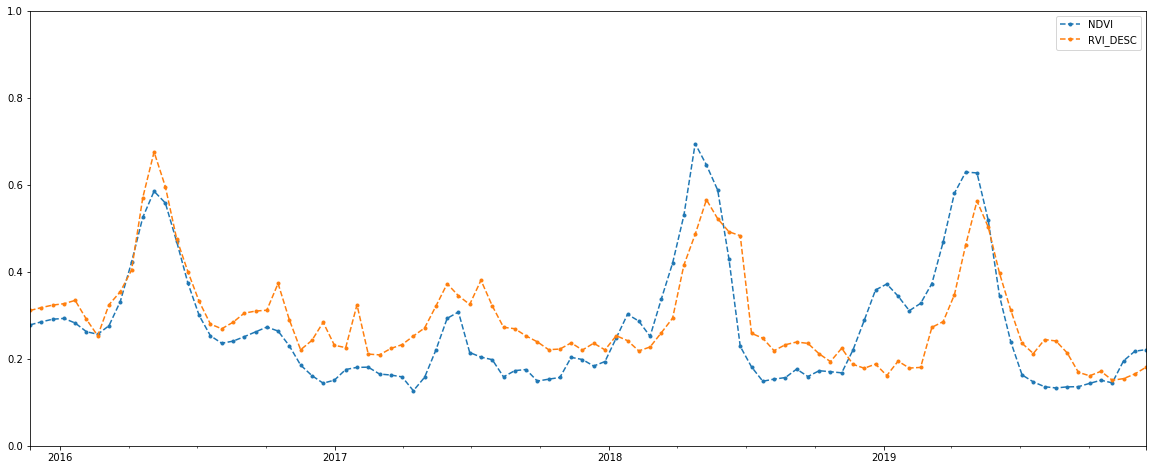

In [36]:
plot = df_mogpr_out_mean.plot(figsize=(20,8), marker='.', linestyle='--')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])